In [2]:
# 필요한 패키지 설치 (최초 1회만 실행)
!pip install pdfplumber -q

# RAG 파라미터 비교 실험

chunk_size, overlap, top_k 파라미터 변경에 따른 RAG 검색 품질 비교

## 비교 대상

| 설정 | chunk_size | overlap | 비고 |
|-----|-----------|---------|------|
| 현재 | 500 | 50 (10%) | 기존 설정 |
| 권장 | 1000 | 200 (20%) | LangChain 권장 |

## 1. 환경 설정

In [3]:
import sys
import os
from pathlib import Path

# 프로젝트 루트 추가
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# OpenMP 충돌 방지 (Windows)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from pdfplumber import open as pdfopen
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from core.llm.factory import create_embeddings
import json

print(f"프로젝트 루트: {project_root}")
print("[OK] 환경 설정 완료")

프로젝트 루트: C:\workspace\enterprise-hr-agent
[OK] 환경 설정 완료


## 2. PDF 문서 로드

In [4]:
pdf_path = project_root / "data" / "company_docs" / "02_회사규정.pdf"

documents = []
with pdfopen(str(pdf_path)) as pdf:
    for i, page in enumerate(pdf.pages):
        text = page.extract_text()
        if text:
            documents.append(Document(page_content=text, metadata={"page": i}))

total_chars = sum(len(d.page_content) for d in documents)
print(f"[OK] PDF 로드 완료")
print(f"페이지 수: {len(documents)}")
print(f"총 글자 수: {total_chars:,}자")

[OK] PDF 로드 완료
페이지 수: 48
총 글자 수: 55,637자


## 3. 청킹 함수 정의

In [5]:
def create_chunks(documents, chunk_size, overlap):
    """문서를 청킹하여 반환"""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        separators=["\n\n", "\n", " ", ""]
    )
    chunks = splitter.split_documents(documents)
    return chunks

print("[OK] 청킹 함수 정의 완료")

[OK] 청킹 함수 정의 완료


## 4. 설정별 인덱스 생성

두 가지 설정으로 FAISS 인덱스 생성:
- 현재: chunk_size=500, overlap=50
- 권장: chunk_size=1000, overlap=200

In [6]:
configs = [
    {"name": "현재 (500/50)", "chunk_size": 500, "overlap": 50},
    {"name": "권장 (1000/200)", "chunk_size": 1000, "overlap": 200},
]

# 임베딩 모델 (Ollama 로컬)
print("임베딩 모델 초기화 중...")
embeddings = create_embeddings(
    provider="ollama",
    model="snowflake-arctic-embed2",
    base_url="http://localhost:11434"
)
print("[OK] 임베딩 모델 초기화 완료")

임베딩 모델 초기화 중...
[OK] 임베딩 모델 초기화 완료


In [7]:
# 설정별 인덱스 생성
indices = {}
chunk_counts = {}

for config in configs:
    print(f"\n{config['name']} 인덱스 생성 중...")
    chunks = create_chunks(documents, config["chunk_size"], config["overlap"])
    chunk_counts[config["name"]] = len(chunks)
    print(f"  청크 수: {len(chunks)}")
    
    vectorstore = FAISS.from_documents(chunks, embeddings)
    indices[config["name"]] = vectorstore
    print(f"  [OK] 인덱스 생성 완료")

print("\n" + "="*50)
print("청크 수 비교:")
for name, count in chunk_counts.items():
    print(f"  {name}: {count} 청크")


현재 (500/50) 인덱스 생성 중...
  청크 수: 147
  [OK] 인덱스 생성 완료

권장 (1000/200) 인덱스 생성 중...
  청크 수: 91
  [OK] 인덱스 생성 완료

청크 수 비교:
  현재 (500/50): 147 청크
  권장 (1000/200): 91 청크


## 5. 테스트 케이스 로드

In [8]:
test_path = project_root / "data" / "finetuning" / "rag_test.json"

with open(test_path, "r", encoding="utf-8") as f:
    test_cases = json.load(f)

print(f"[OK] 테스트 케이스 로드 완료: {len(test_cases)}개")
print("\n테스트 질문 목록:")
for case in test_cases:
    print(f"  {case['id']}. {case['question']}")

[OK] 테스트 케이스 로드 완료: 10개

테스트 질문 목록:
  1. 병가는 어떻게 사용하나요?
  2. 육아휴직은 얼마 동안 쓸 수 있어?
  3. 정직 징계가 뭐야?
  4. 재택근무는 어떻게 하는 거야?
  5. 연장근로 수당은 어떻게 계산해?
  6. 경조사휴가 종류 알려줘
  7. 수습기간이 뭐야?
  8. 복지포인트는 어디에 쓸 수 있어?
  9. 안식휴가는 언제 받을 수 있어?
  10. 회사 VPN은 뭐야?


## 6. 검색 품질 평가 함수

In [9]:
def evaluate_retrieval(vectorstore, test_cases, top_k=3):
    """검색 품질 평가 (키워드 매칭률)"""
    results = []
    
    for case in test_cases:
        docs = vectorstore.similarity_search(case["question"], k=top_k)
        combined_text = " ".join([d.page_content for d in docs])
        
        # 키워드 매칭
        matched = [kw for kw in case["expected_keywords"]
                   if kw.lower() in combined_text.lower()]
        match_rate = len(matched) / len(case["expected_keywords"])
        
        results.append({
            "id": case["id"],
            "question": case["question"],
            "match_rate": match_rate,
            "matched": matched,
            "expected": case["expected_keywords"],
            "missed": [kw for kw in case["expected_keywords"] if kw not in matched]
        })
    
    avg_rate = sum(r["match_rate"] for r in results) / len(results)
    return avg_rate, results

print("[OK] 평가 함수 정의 완료")

[OK] 평가 함수 정의 완료


## 7. 설정별 검색 품질 비교

In [10]:
print("="*60)
print("검색 품질 비교 (키워드 매칭률)")
print("="*60)

comparison = []
all_details = {}

for name, vectorstore in indices.items():
    for top_k in [3, 5]:
        avg_rate, details = evaluate_retrieval(vectorstore, test_cases, top_k)
        config_key = f"{name}, k={top_k}"
        print(f"{config_key}: {avg_rate*100:.1f}%")
        
        comparison.append({
            "config": name,
            "top_k": top_k,
            "avg_match_rate": avg_rate,
            "chunk_count": chunk_counts[name]
        })
        all_details[config_key] = details

검색 품질 비교 (키워드 매칭률)
현재 (500/50), k=3: 88.0%
현재 (500/50), k=5: 95.0%
권장 (1000/200), k=3: 85.0%
권장 (1000/200), k=5: 92.5%


## 8. 상세 결과 분석

In [11]:
import pandas as pd

# 비교 테이블
df = pd.DataFrame(comparison)
print("\n=== 전체 비교 결과 ===")
print(df.to_string(index=False))


=== 전체 비교 결과 ===
       config  top_k  avg_match_rate  chunk_count
  현재 (500/50)      3           0.880          147
  현재 (500/50)      5           0.950          147
권장 (1000/200)      3           0.850           91
권장 (1000/200)      5           0.925           91


In [12]:
# 질문별 상세 비교 (현재 vs 권장, top_k=3)
print("\n=== 질문별 상세 비교 (top_k=3) ===")
print(f"{'ID':<3} {'질문':<25} {'현재':<8} {'권장':<8} {'차이':<8}")
print("-" * 60)

current_details = all_details["현재 (500/50), k=3"]
recommended_details = all_details["권장 (1000/200), k=3"]

for curr, rec in zip(current_details, recommended_details):
    diff = rec["match_rate"] - curr["match_rate"]
    diff_str = f"{diff*100:+.0f}%" if diff != 0 else "0%"
    question_short = curr["question"][:23] + ".." if len(curr["question"]) > 25 else curr["question"]
    print(f"{curr['id']:<3} {question_short:<25} {curr['match_rate']*100:>5.0f}%   {rec['match_rate']*100:>5.0f}%   {diff_str:>6}")


=== 질문별 상세 비교 (top_k=3) ===
ID  질문                        현재       권장       차이      
------------------------------------------------------------
1   병가는 어떻게 사용하나요?              100%      50%     -50%
2   육아휴직은 얼마 동안 쓸 수 있어?          50%      50%       0%
3   정직 징계가 뭐야?                  100%     100%       0%
4   재택근무는 어떻게 하는 거야?            100%     100%       0%
5   연장근로 수당은 어떻게 계산해?           100%     100%       0%
6   경조사휴가 종류 알려줘                100%     100%       0%
7   수습기간이 뭐야?                    80%     100%     +20%
8   복지포인트는 어디에 쓸 수 있어?           50%      50%       0%
9   안식휴가는 언제 받을 수 있어?           100%     100%       0%
10  회사 VPN은 뭐야?                 100%     100%       0%


## 9. 결과 시각화

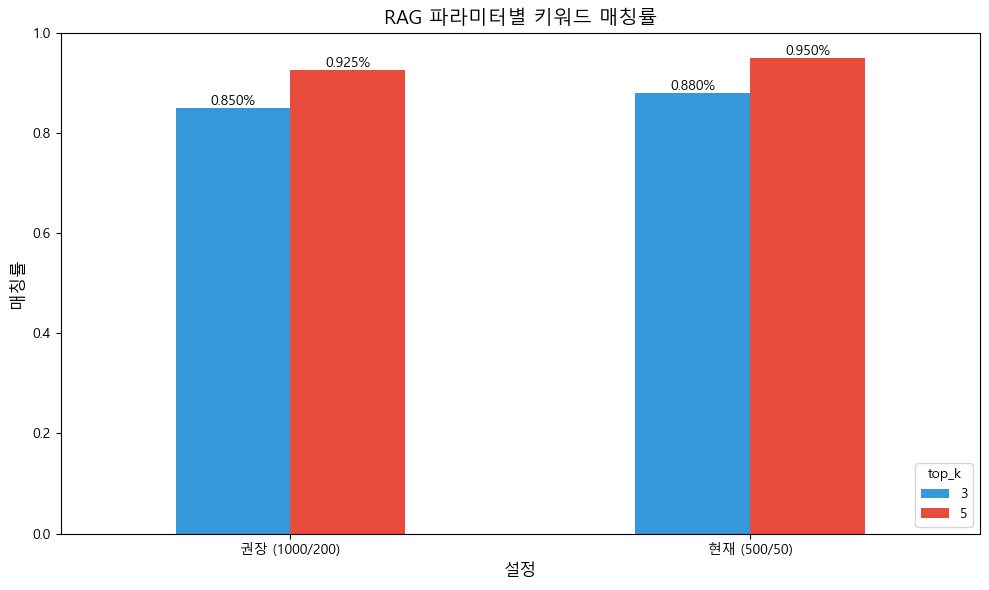

In [15]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 피벗 테이블
df_pivot = df.pivot(index="config", columns="top_k", values="avg_match_rate")

# 바 차트
ax = df_pivot.plot(kind="bar", figsize=(10, 6), color=["#3498db", "#e74c3c"])
plt.title("RAG 파라미터별 키워드 매칭률", fontsize=14)
plt.xlabel("설정", fontsize=12)
plt.ylabel("매칭률", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="top_k", loc="lower right")
plt.ylim(0, 1)

# 값 표시
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f%%", label_type="edge", fontsize=10)

plt.tight_layout()
plt.show()

## 10. 최종 권장사항

In [16]:
# 최적 설정 찾기
best = max(comparison, key=lambda x: x["avg_match_rate"])

print("="*60)
print("최종 권장사항")
print("="*60)
print(f"\n최적 설정: {best['config']}")
print(f"top_k: {best['top_k']}")
print(f"매칭률: {best['avg_match_rate']*100:.1f}%")
print(f"청크 수: {best['chunk_count']}")

# 현재 vs 최적 비교
current = next(c for c in comparison if c["config"] == "현재 (500/50)" and c["top_k"] == 3)
improvement = best["avg_match_rate"] - current["avg_match_rate"]

print(f"\n현재 대비 개선: {improvement*100:+.1f}%")

최종 권장사항

최적 설정: 현재 (500/50)
top_k: 5
매칭률: 95.0%
청크 수: 147

현재 대비 개선: +7.0%


In [17]:
# 결과 저장
result_summary = {
    "comparison": comparison,
    "best_config": best,
    "improvement": improvement
}

output_path = project_root / "data" / "finetuning" / "rag_parameter_comparison.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(result_summary, f, ensure_ascii=False, indent=2)

print(f"\n결과 저장: {output_path}")


결과 저장: C:\workspace\enterprise-hr-agent\data\finetuning\rag_parameter_comparison.json
